In [21]:
pip install latex

Note: you may need to restart the kernel to use updated packages.


In [22]:
import numpy as np
from dgamod import *
import cmath as cm
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import random
import pandas as pd
import configparser
import sys
import os
import matplotlib.animation as animation
from drl_grams import *
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D

%matplotlib widget
mpl.rcParams.update({'font.size': 12})
plt.rcParams['axes.axisbelow'] = True
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrkmyc')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["b", "g", "r", 'k','y' , 'm','tab:orange', 'tab:cyan', 'tab:brown', 'slategrey', 'deeppink' ]) 

#### 54 Jornadas Argentinas de Informática e investigación Operativa

# Optimización de la Transmisión de Estados Cuánticos en Cadenas de Qubits usando Deep Reinforcement Learning y Algoritmos Genéticos

Sofía Perón Santana

--- 

Este notebook resume los resultados y gráficos presentados en el artículo *Optimización de la Transmisión de Estados Cuánticos en Cadenas de Qubits usando Deep Reinforcement Learning y Algoritmos Genéticos* presentado en la 54 JAIIO. En el mismo se comparan los dos enfoques mencionados y se cuantifica su desempeño para la optimización de transmisiones de estados cuánticos en cadenas de qubits. 

### Algoritmos genéticos vs DRL

El primer gráfico presentado muestra las fidelidades máximas y medias logradas con ambos métodos para distintos largos de cadenas de qubits. Los directorios con los resultados crudos se incluyen en este repositorio en sus respectivos directorios `drl_preliminary_results` y `ga_preliminary_results`. Se busca resumir algunas herramientas útiles para visualizar los datos obtenidos. 

### Extracción de datos de fidelidad 

#### Para DRL:

Cada directorio contiene los resultados del entrenamiento para una longitud de cadena específica.  
Se recuperan los 10 valores más altos de fidelidad obtenidos durante el entrenamiento para cada longitud de cadena.

#### Para GA: 

Se realizaron pruebas para distintas longitudes dentro del directorio principal, se encuentran los directorios de las distintas pruebas (con distintos parámetros de algoritmo). A su vez, dentro de cada uno de ellos se halla un archivo de resumen del que extraemos las fidelidades máximas obtenidas y los directorios con las secuencias de acciones para cada longitud de cadena.

In [23]:
path = 'drl_preliminary_results/'

dimensions = [8,12,16,20,24,32]
fidelities = pd.DataFrame()

fidelities = pd.DataFrame(columns=['chain_length', 'method', 'fid'])

for dimension in dimensions:
    directory = path + f'n{dimension}_og_zhangn{dimension}_off_size120'
    best_fids = np.loadtxt(directory + '/best_fidelities.txt', dtype=np.float32)
    for fid in best_fids:
        fidelities = pd.concat([fidelities, pd.DataFrame({'chain_length': [dimension], 'method': ['zhang'], 'fid': [fid]})], ignore_index=True)

# extraccion de estadisticas DRL
grouped_df = fidelities.groupby('chain_length')
grouped_df
drl_mean = grouped_df['fid'].mean()
drl_std = grouped_df['fid'].std()
drl_min = grouped_df['fid'].min()
drl_max = grouped_df['fid'].max()

# Lectura de resultados de Algoritmo Genético (GA)

ga_results = pd.read_csv('genetic_algorithm_results/rb_zhang/nvsmaxfid.dat', header=None, delimiter=',', names=['chain_length', 'sample', 'fid', 'ttime', 'generations', 'cputime'])
ga_results['method'] = 'ga'

# Convertir todas las columnas excepto 'method' a numérico
for col in ga_results.columns:
    if col != 'method':
        ga_results[col] = pd.to_numeric(ga_results[col], errors='coerce')

# Filtramos dimensiones bajas para matchear con DRL
ga_results = ga_results[ga_results['chain_length'].notna() & (ga_results['chain_length'] <= 32)]

# extraccion de estadisticas ga
ga_grouped = ga_results.groupby('chain_length')
ga_mean = ga_grouped['fid'].mean()
ga_std = ga_grouped['fid'].std()
ga_max = ga_grouped['fid'].max()

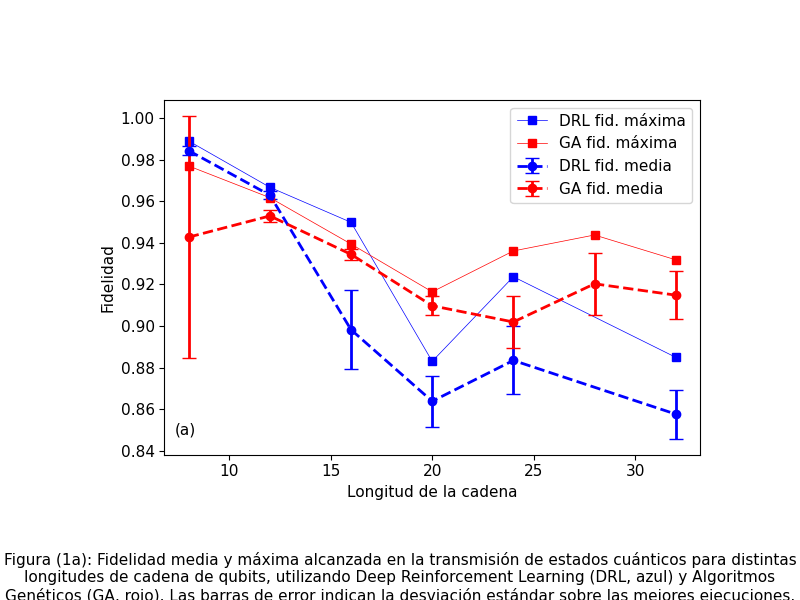

In [24]:
plt.figure(figsize=(8, 6))
fs = 11

plt.errorbar(dimensions, drl_mean, yerr=drl_std, fmt='o--', label='DRL fid. media', color='blue', capsize=5)
plt.plot(dimensions, drl_max, 's-', color='blue', label='DRL fid. máxima', linewidth=0.5)

plt.errorbar(ga_mean.index, ga_mean, yerr=ga_std, fmt='o--', label='GA fid. media', color='red', capsize=5)
plt.plot(ga_max.index, ga_max, 's-', color='red', label='GA fid. máxima', linewidth=0.5)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.xlabel('Longitud de la cadena', fontsize=fs)
plt.ylabel('Fidelidad', fontsize=fs)
plt.legend(fontsize=fs)
plt.text(0.02, 0.09, '(a)', transform=plt.gca().transAxes, fontsize=fs, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
#plt.savefig('zhang_drl_ga_fidelidades.png', dpi=1600, bbox_inches='tight')

plt.figtext(
    0.5, 0.08,
    "Figura (1a): Fidelidad media y máxima alcanzada en la transmisión de estados cuánticos para distintas longitudes de cadena de qubits, utilizando Deep Reinforcement Learning (DRL, azul) y Algoritmos Genéticos (GA, rojo). Las barras de error indican la desviación estándar sobre las mejores ejecuciones.",
    wrap=True, horizontalalignment='center', fontsize=fs, ha='center', va='top'
)
plt.tight_layout(pad = 6.0)


## Comparación de soluciones obtenidas

A continuación, se muestran las probabilidades de transición asociadas a las secuencias obtenidas por cada uno de los métodos. Los resultados observados son para una cadena de 16 qubits.

In [25]:
n = 16  # Cambiar a la longitud de cadena deseada
samples = np.arange(0,10,1)
ga_sequences = uniformize_data('ga',**{'directory': f'genetic_algorithm_results/rb_zhang/n{n}/', 'n':n})
zhang_sequences = uniformize_data('zhang',**{'file' : f'drl_preliminary_results/n{n}_og_zhangn{n}_off_size120/best_action_sequences.txt'})

/home/sofi/miniconda3/envs/drlenv/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


(array([0.  , 0.5 , 0.95]), [Text(1, 0, ''), Text(1, 0, ''), Text(1, 0, '')])

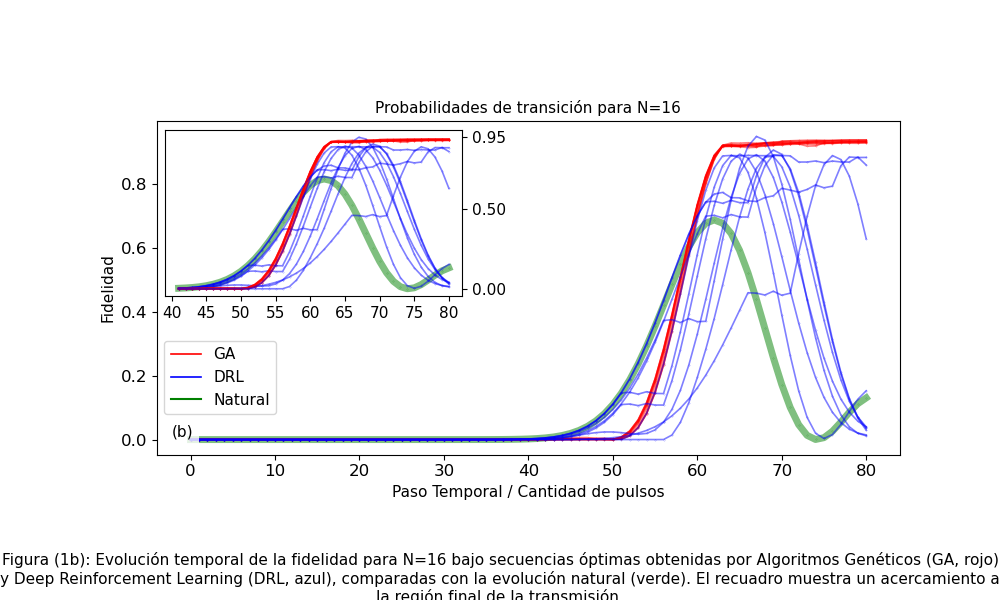

In [26]:
plt.figure(figsize=(10, 6))

for sample in samples:
    forced_evol, natural_evol = fid_evolution(ga_sequences[sample][:], n, dt=0.15, b=100, label="", actions="original", add_natural=True)
    plt.plot(forced_evol, '-o', label=f'GA {sample}', color='red', alpha=0.5, linewidth=1.2, markersize=0.2)
for sample in samples:
    forced_evol, natural_evol = fid_evolution(zhang_sequences[sample][:], n, dt=0.15, b=100, label="", actions="original", add_natural=True)
    plt.plot(forced_evol, '-o', label=f'GA {sample}', color='blue', alpha=0.5, linewidth=1.2, markersize=0.2)

plt.plot(natural_evol, '-o', label='Natural', color='green', alpha=0.5, linewidth=5, markersize=0.2, zorder = -2)
# Mover etiquetas de los ejes al eje principal
plt.xlabel('Paso Temporal / Cantidad de pulsos', fontsize=fs)
plt.ylabel('Fidelidad', fontsize=fs)
# Create a personalized legend

legend_elements = [
    Line2D([0], [0], color='red', lw=1.2, label='GA'),
    Line2D([0], [0], color='blue', lw=1.2, label='DRL'),
    Line2D([0], [0], color='green', lw=1.5, label='Natural')
]
plt.legend(handles=legend_elements, fontsize=fs, loc='lower left', bbox_to_anchor=(0, 0.1))
plt.text(0.02, 0.09, '(b)', transform=plt.gca().transAxes, fontsize=fs, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.title(f'Probabilidades de transición para N={n}', fontsize=fs)

plt.figtext(
    0.5, 0.08,
    "Figura (1b): Evolución temporal de la fidelidad para N=16 bajo secuencias óptimas obtenidas por Algoritmos Genéticos (GA, rojo) y Deep Reinforcement Learning (DRL, azul), comparadas con la evolución natural (verde). El recuadro muestra un acercamiento a la región final de la transmisión.",
    wrap=True, horizontalalignment='center', fontsize=fs, ha='center', va='top'
)

# Agregar inset
ax_inset = inset_axes(plt.gca(), width="40%", height="50%", loc="upper left")
ax_inset.plot(range(len(forced_evol))[int(-2.5*n):],natural_evol[int(-2.5*n):], '-o', label='Natural', color='green', alpha=0.5, linewidth=5, markersize=0.2, zorder = -2)
for sample in samples:
    forced_evol, natural_evol = fid_evolution(ga_sequences[sample][:], n, dt=0.15, b=100, label="", actions="original", add_natural=True)
    ax_inset.plot(range(len(forced_evol))[int(-2.5*n):], forced_evol[int(-2.5*n):], '-o', color='red', alpha=0.5, linewidth=1.2, markersize=0.2)
    forced_evol, natural_evol = fid_evolution(zhang_sequences[sample][:], n, dt=0.15, b=100, label="", actions="original", add_natural=True)
    ax_inset.plot(range(len(forced_evol))[int(-2.5*n):], forced_evol[int(-2.5*n):], '-o', color='blue', alpha=0.5, linewidth=1.2, markersize=0.2)
    ax_inset.yaxis.tick_right()
    ax_inset.tick_params(axis='both', which='major', labelsize=fs - 6)
# ax_inset.set_xticks([60,70,80])
ax_inset.set_yticks([0., 0.5, 0.95])
ax_inset.tick_params(axis='x', labelsize=fs - 6)
ax_inset.tick_params(axis='y', labelsize=fs - 6)    
plt.tight_layout(pad=6.0)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)



## Tiempos de CPU

Es interesante destacar también que el algoritmo genético presenta una gran ventaja respecto a la eficiencia computacional. El siguiente gráfico muestra el tiempo que requiere entrenar un modelo de DRL y el tiempo que requiere una corrida de algoritmo genético. Dado que en RL no se pudo hacer estadística sobre los tiempos de entrenamiento ya que requeriría entrenar repetidas veces y son tiempos largos, comparamos con el valor máximo de tiempo de búsqueda en el genético. 

Es posible que los tiempos de ejecución en DRL puedan acortarse mediante optimizaciones. Sin embargo, dada la naturaleza de implementación del algoritmo genético, este es fácilmente paralelizable en GPU lo que permite reducir ampliamente los tiempos de cómputo.

Text(0.5, 0.1, 'Figura (2): Tiempos de CPU requeridos para entrenar modelos de Deep Reinforcement Learning (DRL, azul) y para encontrar soluciones óptimas con Algoritmos Genéticos (GA, rojo) para distintas longitudes de cadena de qubits. Escala logarítmica en el eje y.')

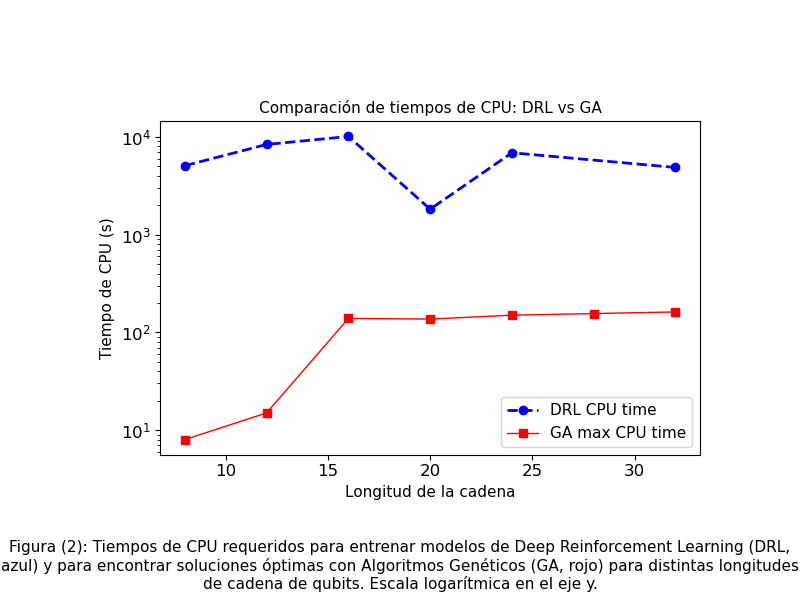

In [32]:
drl_times = pd.read_csv('drl_preliminary_results/cpu_times.csv')

ga_mean = ga_grouped['cputime'].mean()
ga_std = ga_grouped['cputime'].std()
ga_max = ga_grouped['cputime'].max()

plt.figure(figsize=(8, 6))
plt.plot(dimensions, drl_times['cpu_time'], 'o--', label='DRL CPU time', color='blue')
plt.plot(ga_max.index, ga_max.values, 's-', label='GA max CPU time', color='red', linewidth=1)
plt.xlabel('Longitud de la cadena', fontsize=fs)
plt.ylabel('Tiempo de CPU (s)', fontsize=fs)
plt.legend(fontsize=fs)
plt.title('Comparación de tiempos de CPU: DRL vs GA', fontsize=fs)
plt.yscale('log')
plt.tight_layout(pad=6.0)

plt.figtext(
    0.5, 0.1,
    "Figura (2): Tiempos de CPU requeridos para entrenar modelos de Deep Reinforcement Learning (DRL, azul) y para encontrar soluciones óptimas con Algoritmos Genéticos (GA, rojo) para distintas longitudes de cadena de qubits. Escala logarítmica en el eje y.",
    wrap=True, horizontalalignment='center', fontsize=fs, ha='center', va='top'
)

## Extensión a más dimensiones y alta tolerancia

Al presentar tiempos de cómputo menores, es posible extender los resultados a mayores dimensiones. 